<a href="https://colab.research.google.com/github/karthikpuranik11/Hope-Speech-Detection-/blob/Tamil/Tamil/mBERT%2BbiLSTM_Tamil.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers==3.3.1

     |████████████████████████████████| 1.1MB 12.3MB/s 
     |████████████████████████████████| 3.0MB 49.2MB/s 
     |████████████████████████████████| 890kB 48.1MB/s 
     |████████████████████████████████| 1.1MB 47.2MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=8e1a7e2b4316e8c90b92de525a1764d74bbf28a90a90e97ddb39a198ef128617
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

In [3]:
train=pd.read_csv('/content/tamil_hope_first_train.tsv', header=None, names=['tweets','label'], sep="\t")
train['labels']=LabelEncoder().fit_transform(train['label'])
train=train.drop(columns='label')
train

,tweets,labels
0,Realme india product,2
1,I also don't have tiktok hello and allnBut I'm...,0
2,Thalaivare..neengale inum one plus mobile vach...,1
3,Annee varanda thondai.. corona virus affect pa...,0
4,5views but 18likes,1
...,...,...
16155,7pm correcta erukum mg bro,0
16156,Intha karutha mudija varaikum Neengalum ellark...,1
16157,And neenga adhiyavasiyam nu soldra apps like t...,1
16158,Daii sekram mater ku vada,0


In [4]:
val=pd.read_csv('/content/tamil_hope_first_dev.tsv', header=None, names=['tweets','label'], sep="\t")
val['labels']=LabelEncoder().fit_transform(val['label'])
val=val.drop(columns='label')
val

,tweets,labels
0,Mg bro eve 6 o clock video post pannuga,0
1,8.00 pm bro plss,2
2,Bro ivan kitta sonna . Ivan change' pannidava ...,0
3,@Varnajalam Mini Crafts adhum crrct thaan Akka 🤣,1
4,எல்லா குழந்தைகளும் நல்ல எண்ணம்,0
...,...,...
2013,Share karo app use panlama,1
2014,@R SWAGxOP kelattu kapothi maari nee pesathada...,1
2015,Yow yaean yaa kelappi vidringa ipd,1
2016,Hey bro. Ur doing amazing...,2


In [5]:
def punc(df):
    df['tweets'] = df['tweets'].str.replace(r"[+/#@&*$%:]",'')
    print(df)
punc(train)
punc(val)

                                                  tweets  labels
0                                   Realme india product       2
1      I also don't have tiktok hello and allnBut I'm...       0
2      Thalaivare..neengale inum one plus mobile vach...       1
3      Annee varanda thondai.. corona virus affect pa...       0
4                                     5views but 18likes       1
...                                                  ...     ...
16155                         7pm correcta erukum mg bro       0
16156  Intha karutha mudija varaikum Neengalum ellark...       1
16157  And neenga adhiyavasiyam nu soldra apps like t...       1
16158                          Daii sekram mater ku vada       0
16159                             Bro put Redmi 8 gaming       0

[16160 rows x 2 columns]
                                                 tweets  labels
0               Mg bro eve 6 o clock video post pannuga       0
1                                      8.00 pm bro plss       2
2 

In [6]:
import pandas as pd
from torch.utils.data import Dataset,DataLoader

class RFDataset(Dataset):
  def __init__(self,tweets,labels,tokenizer,max_len):
    self.tweets = tweets
    self.labels = labels
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.tweets)
  
  def __getitem__(self,item):
    tweets = str(self.tweets[item])
    labels = self.labels[item]

    encoding = self.tokenizer.encode_plus(
        tweets,
        add_special_tokens=True,
        max_length = self.max_len,
        return_token_type_ids = False,
        padding = 'max_length',
        return_attention_mask= True,
        return_tensors='pt',
        truncation=True
    )

    return {
        'tweets' : tweets,
        'input_ids' : encoding['input_ids'].flatten(),
        'attention_mask' : encoding['attention_mask'].flatten(),
        'labels' : torch.tensor(labels,dtype=torch.long)

    }

In [7]:
 
print('Training set size:',train.shape)
#Uncomment the next line when we have the test data
#print('Testing set size:',test.shape)
print('validation set size:',val.shape)

Training set size: (16160, 2)
validation set size: (2018, 2)


In [8]:
import numpy as np

from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                  np.unique(train.labels.values),
                                                  train.labels.values)
class_weights

array([0.85137769, 0.68428184, 2.74689784])

In [9]:
def create_data_loader(df,tokenizer,max_len,batch_size):
  ds = RFDataset(
      tweets = df.tweets.to_numpy(),
      labels = df.labels.to_numpy(),
      tokenizer = tokenizer,
      max_len = max_len
  )

  return DataLoader(ds,
                    batch_size = batch_size,
                    shuffle = True,
                    num_workers=4)

In [10]:
from transformers import XLNetTokenizer,XLNetModel,AdamW,get_linear_schedule_with_warmup,AutoModel,AutoTokenizer
device = 'cuda'
PRE_TRAINED_MODEL_NAME = 'bert-base-multilingual-uncased'
tokenizer = AutoTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)


In [11]:
BATCH_SIZE = 32
MAX_LEN = 128
train_data_loader = create_data_loader(train,tokenizer,MAX_LEN,BATCH_SIZE)
val_data_loader = create_data_loader(val,tokenizer,MAX_LEN,BATCH_SIZE)

In [12]:
BERT_model = AutoModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [13]:
import torch
import torch.nn as nn
class RFClassifier(nn.Module):
  def __init__(self, n_classes):
    super(RFClassifier, self).__init__()
    self.auto = AutoModel.from_pretrained('bert-base-multilingual-uncased')
    self.lstm = nn.LSTM(768, 256, batch_first=True,bidirectional=True)
    self.linear = nn.Linear(256*2, 128)
    self.relu = nn.ReLU()
    self.dropout = nn.Dropout(0.4)
    self.out = nn.Linear(128, n_classes)
  
  def forward(self, input_ids, attention_mask):
    sequence_output, pooled_output = self.auto(input_ids, 
               attention_mask=attention_mask)

    # sequence_output has the following shape: (batch_size, sequence_length, 768)
    lstm_output, (h,c) = self.lstm(sequence_output) ## extract the 1st token's embeddings
    hidden = torch.cat((lstm_output[:,-1, :256],lstm_output[:,0, 256:]),dim=-1)
    linear_output = self.linear(lstm_output[:,-1].view(-1,256*2)) ### assuming that you are only using the output of the last LSTM cell to perform classification

    return linear_output

In [14]:
model = RFClassifier(3)
model = model.to(device)

In [15]:
EPOCHS = 3
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [16]:
def train_epoch(model,data_loader,loss_fn,optimizer,device,scheduler,n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0

    for data in data_loader:
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)
        labels = data['labels'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
            )
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs,labels)

        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

In [17]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      labels = d["labels"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, labels)
      correct_predictions += torch.sum(preds == labels)
      losses.append(loss.item())
  return correct_predictions.double() / n_examples, np.mean(losses)

In [18]:

import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [19]:
from collections import defaultdict
import torch
 
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
 
 
  start_time = time.time()
  train_acc,train_loss = train_epoch(
      model,
      train_data_loader,
      loss_fn,
      optimizer,
      device,
      scheduler,
      len(train)
  )
   
 
#  val_acc,val_loss = eval_model(
#      model,
#      val_data_loader,
#      loss_fn,
#      device,
#      len(val)
#  )

  end_time = time.time()
  epoch_mins, epoch_secs = epoch_time(start_time, end_time)
  print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
  print(f'Train Loss {train_loss} accuracy {train_acc}')
 # print(f'Val Loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
#  history['val_acc'].append(val_acc)
#  history['val_loss'].append(val_loss)

  if train_acc > best_accuracy:
    torch.save(model.state_dict(),'multilingual-bert-base-uncased(25_Epochs).bin')
    best_accuracy = train_acc

Epoch: 01 | Epoch Time: 6m 32s
Train Loss 0.912290086368523 accuracy 0.5419554455445544

Epoch: 02 | Epoch Time: 6m 38s
Train Loss 0.7634747662166558 accuracy 0.5895420792079208

Epoch: 03 | Epoch Time: 6m 38s
Train Loss 0.7188810471260901 accuracy 0.6323638613861386



Text(0.5, 0, 'Epoch')

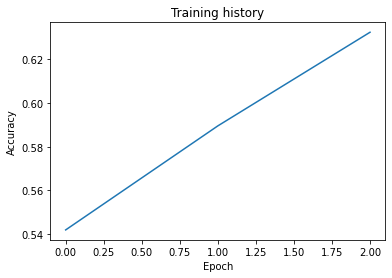

In [20]:
import matplotlib.pyplot as plt
plt.plot(history['train_acc'], label='train accuracy')
#plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
#plt.legend()
#plt.ylim([0, 1]);

In [21]:
val_acc, _ = eval_model(
  model,
  val_data_loader,
  loss_fn,
  device,
  len(val) #Change it to test when you have the test results
)
val_acc.item()

0.5916749256689792

In [22]:
def get_predictions(model, data_loader):
  model = model.eval()
  sentence = []
  predictions = []
  prediction_probs = []
  real_values = []
  with torch.no_grad():
    for d in data_loader:
      tweets = d["tweets"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      labels = d["labels"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      sentence.extend(tweets)
      predictions.extend(preds)
      prediction_probs.extend(outputs)
      real_values.extend(labels)
  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return sentence, predictions, prediction_probs, real_values

In [23]:

y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  val_data_loader
)

In [24]:
class_name = ['Hope_speech','Non_hope_speech','not-Tamil']

In [25]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test, y_pred, target_names=class_name,zero_division=0))

                 precision    recall  f1-score   support

    Hope_speech       0.50      0.41      0.45       757
Non_hope_speech       0.64      0.70      0.67       998
      not-Tamil       0.61      0.71      0.65       263

       accuracy                           0.59      2018
      macro avg       0.58      0.61      0.59      2018
   weighted avg       0.58      0.59      0.58      2018



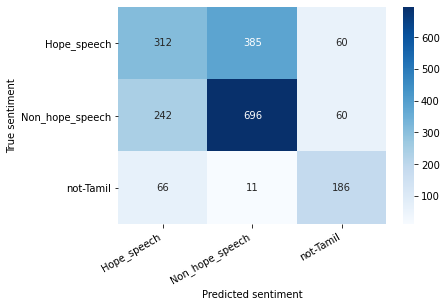

In [26]:
import seaborn as sns
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_name, columns=class_name)
show_confusion_matrix(df_cm)